In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
import tensorflow_datasets as tfds
from keras.utils import plot_model
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.constraints import max_norm

In [2]:
#Load tfds dataset
ds, info = tfds.load('oxford_flowers102', with_info=True, as_supervised=True)
test = ds['test']
train = ds['train']
validation = ds['validation']

#Dataset split sizes
train_size = train.cardinality()
print("Test size:", test.cardinality())
print("Train size", train_size)
print("Validation size", validation.cardinality())

Test size: tf.Tensor(6149, shape=(), dtype=int64)
Train size tf.Tensor(1020, shape=(), dtype=int64)
Validation size tf.Tensor(1020, shape=(), dtype=int64)


In [3]:
def resize_image(image, label):
  image = tf.image.resize(image, (200, 200), preserve_aspect_ratio=False)/255.0
  return image, label

batch_size = 256

test_batches = test.map(resize_image).batch(batch_size)
train_batches = train.cache().map(resize_image).shuffle(train_size, reshuffle_each_iteration=True).repeat(60).batch(batch_size).prefetch(tf.data.AUTOTUNE)
validation_batches = validation.cache().map(resize_image).batch(batch_size).prefetch(tf.data.AUTOTUNE)

In [4]:
#Number of flower classes
num_classes = info.features['label'].num_classes
print("Number of flower classes:", num_classes)

Number of flower classes: 102


In [5]:
#Getting the shape of the images. None = varies in size in height and width. Depth = 3 meaning RGB 3 channel image
print(info.features['image'].shape)

(None, None, 3)


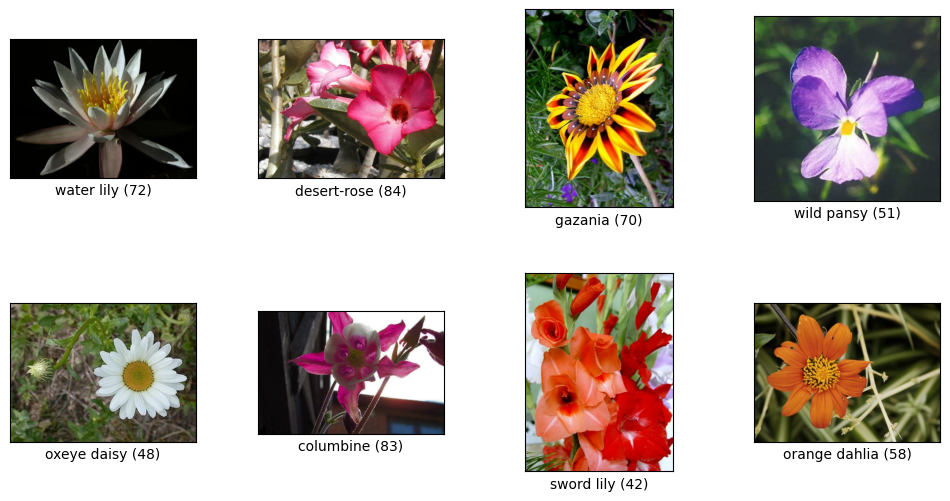

Figure(1200x600)


In [6]:
#Showing some examples of the ds with varying image size and classes
print(tfds.show_examples(train, info, rows=2, cols=4))

In [7]:
#Data augmentation
data_augmentation = keras.Sequential([
  layers.RandomContrast(0.5),
  layers.RandomFlip("horizontal_and_vertical"),
  layers.RandomTranslation(0.2, 0.2, fill_mode='reflect'),
  layers.RandomZoom(0.3, fill_mode='reflect'),
  layers.RandomRotation(0.2)
])

In [8]:
#Defining our model with its layers
model = keras.Sequential([
    data_augmentation,
    layers.Conv2D(16, 3, strides=1, padding='same', activation='relu', kernel_constraint=max_norm(2.)),
    layers.MaxPooling2D(pool_size=(2, 2), strides=None, padding='valid'),
    layers.Conv2D(32, 3, strides=1, padding='same', activation='relu', kernel_constraint=max_norm(2.)),
    layers.MaxPooling2D(pool_size=(2, 2), strides=None, padding='valid'),
    layers.Conv2D(64, 3, strides=1, padding='same', activation='relu', kernel_constraint=max_norm(2.)),
    layers.MaxPooling2D(pool_size=(2, 2), strides=None, padding='valid'),
    layers.Flatten(),
    layers.Dense(1024, activation='relu', kernel_constraint=max_norm(2.)),
    layers.Dropout(0.5),
    layers.Dense(num_classes, activation='softmax')
])

In [9]:
#Compiles our model
model.compile(
  optimizer=keras.optimizers.Adam(learning_rate=0.0001),
  loss=keras.losses.SparseCategoricalCrossentropy(), #Sparse means labels can be integers rather than one-hot enocded
  metrics=['accuracy']
  )

In [10]:
#Adding callbacks
callbacks = [
    #keras.callbacks.ModelCheckpoint(filepath='checkpoint.h5', save_best_only=True, monitor='val_loss'),
    #keras.callbacks.EarlyStopping(patience=5)
]

In [11]:
#Train model and store results
train_history = model.fit(x=train_batches, epochs=20, callbacks=callbacks, validation_data=validation_batches)

Epoch 1/20
240/240 [==============================] - 89s 295ms/step - loss: 3.9050 - accuracy: 0.0932 - val_loss: 3.2992 - val_accuracy: 0.2304
Epoch 2/20
240/240 [==============================] - 64s 265ms/step - loss: 3.0943 - accuracy: 0.2187 - val_loss: 2.9733 - val_accuracy: 0.2990
Epoch 3/20
240/240 [==============================] - 65s 268ms/step - loss: 2.6493 - accuracy: 0.3056 - val_loss: 2.8681 - val_accuracy: 0.3157
Epoch 4/20
240/240 [==============================] - 64s 265ms/step - loss: 2.3285 - accuracy: 0.3664 - val_loss: 2.8679 - val_accuracy: 0.3235
Epoch 5/20
240/240 [==============================] - 64s 264ms/step - loss: 2.1087 - accuracy: 0.4114 - val_loss: 2.8084 - val_accuracy: 0.3510
Epoch 6/20
240/240 [==============================] - 64s 264ms/step - loss: 1.9132 - accuracy: 0.4558 - val_loss: 2.8618 - val_accuracy: 0.3637
Epoch 7/20
240/240 [==============================] - 64s 264ms/step - loss: 1.7432 - accuracy: 0.4931 - val_loss: 2.9219 - val_ac

In [12]:
model.evaluate(test_batches)

25/25 [==============================] - 11s 430ms/step - loss: 4.1717 - accuracy: 0.3784


[4.171681880950928, 0.37843552231788635]

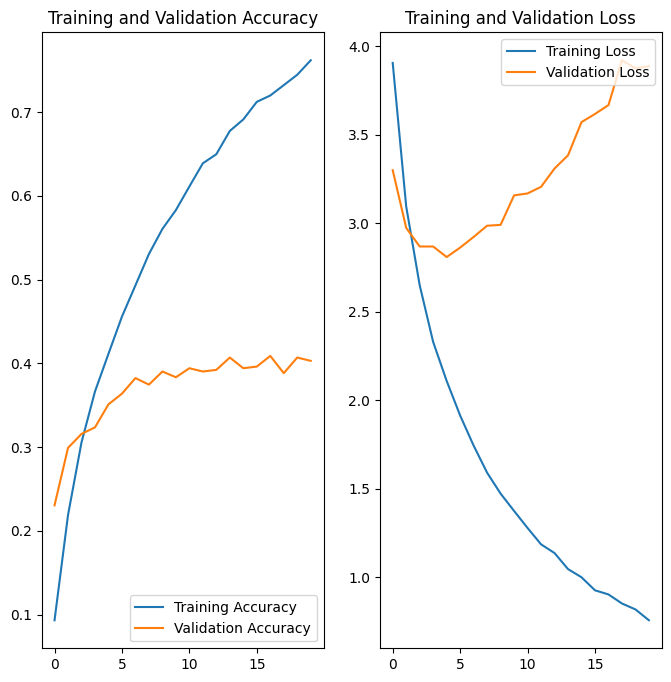

In [13]:
# Creating plots of the loss of accuracy on the training and validation sets
acc = train_history.history['accuracy']
val_acc = train_history.history['val_accuracy']
loss = train_history.history['loss']
val_loss = train_history.history['val_loss']

epochs_range = range(20)

# Training and Validation Accuracy
plt.figure(figsize = (8,8))
plt.subplot(1,2,1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

# Training and Validation Loss
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

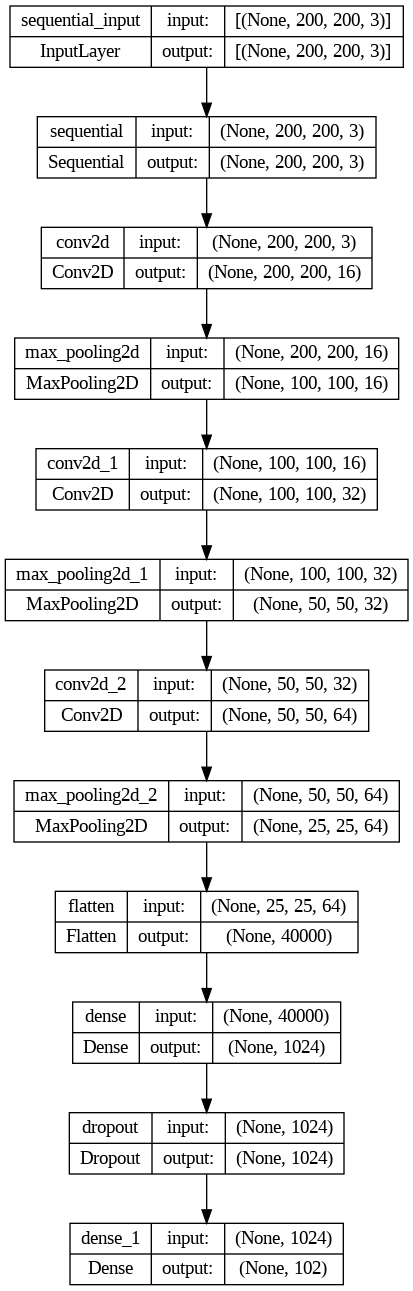

In [14]:
plot_model(model, show_shapes=True, to_file='residual_module.png')

In [15]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 200, 200, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 200, 200, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 100, 100, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 100, 100, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 50, 50, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 50, 50, 64)       